### Import dependencies

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import Normalize

import rasterio
import tifffile as tf

from netCDF4 import Dataset

import seaborn as sns
from scipy.integrate import solve_ivp 
from scipy.ndimage import zoom
from scipy import ndimage

import yaml

from PIL import Image

import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


c:\Users\bleser\.conda\envs\floodshealth\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\bleser\.conda\envs\floodshealth\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\bleser\.conda\envs\floodshealth\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\bleser\.conda\envs\floodshealth\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


ModuleNotFoundError: No module named 'cartopy'

### Read in maps (now one time step, later timeseries)

In [185]:
#### set directories & load data ####

# Directory with input data
mapsDir = 'C:/FloodsAndHealthTool-main/examples/Data bronnen/'
mapsDirpre = 'C:/FloodsAndHealthTool-main/output/preprocessing/' #output folder preprocessing
ds_out = 'C:/FloodsAndHealthTool-main/output/' #output folder

# Load maps
flood = tf.imread(mapsDir+'flooded_zoom.tif')
demographic = tf.imread(mapsDir+'merged_ch_ad_popdens.nc') 

# Open the demographic raster dataset with the 3 bands
input_ds = gdal.Open(demographic)

if input_ds is None:
    print("Failed to open the input raster dataset.")
else:
    # Get the specified band
    children = input_ds.GetRasterBand(1)
    adults = input_ds.GetRasterBand(2)
    popdens = input_ds.GetRasterBand(3)

    

# remove no data values ---- still necessary?
flood[flood < -3.402822e+38] = np.nan
demographic[demographic < -3.402822e+38] = np.nan #or for each band? 


Define desired pathogen, source, concentration and dose-response parameters

In [ ]:
# User defined settings for pathogen and scenario selection

pathogen = 'E.coli' # select the pathogen for the simulation. Option at the moment is only 'E.coli'
source = 'Sewer_and_pluvial' #select the source of the pathogen. At the moment only 'Sewer_and_pluvial'
conc = 'max' #select the concentration of the pathogen: options are 'min' and 'max'
doseresp = 'poisson' #select the dose response curve of the pathogen for infection calculation. Either 'beta poisson' (keyword: 'poisson') or exponantial ('exp', not yet included)

#form values for poisson distribution
N50 = 896 #constant for the beta poisson infection risk calculation
NoE  = 4  #number of events per year 
alpha = 0.145 #form value for poisson distribution

Can be deleted? 

In [ ]:
### I believe this one can be deletes....but maybe wait until the end of the week.

"""
with rasterio.open('pop_dens.tif') as src:
    window= rasterio.windows.Window(400, 525, 150, 150)
    subset = src.read(window=window)
    transform = src.window_transform(window)
    meta = src.meta.copy()
    meta.update({
        'height': window.height,
        'width': window.width,
        'transform': transform
    })

 
# Write the subset to a new file   
with rasterio.open('pop_dens_zoom.tif', 'w', **meta) as dst:
    dst.write(subset)

"""

"\nwith rasterio.open('pop_dens.tif') as src:\n    window= rasterio.windows.Window(400, 525, 150, 150)\n    subset = src.read(window=window)\n    transform = src.window_transform(window)\n    meta = src.meta.copy()\n    meta.update({\n        'height': window.height,\n        'width': window.width,\n        'transform': transform\n    })\n\n \n# Write the subset to a new file   \nwith rasterio.open('pop_dens_zoom.tif', 'w', **meta) as dst:\n    dst.write(subset)\n\n"

Do we need to put the bounding box here for the demographic data? Now, the demographic data is for the whole country in 3 bands: band 1 children counts, band 2 adult counts and band 3 population density. 

How do we plot the maps with the 3 different bands? Better than also after putting the bounding box on it?

### Plot maps ###

Flooded area, population density in flooded area, adults & children in flooded area

---> should we save these maps to the output folder?

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3740392751.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)                                               # add colorbar


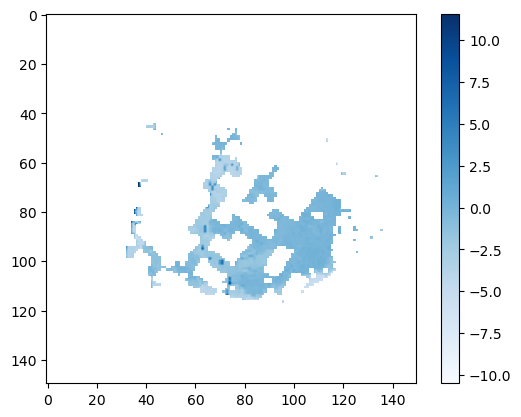

In [ ]:
### plot the flooding map ###

cmap = mpl.colormaps['Blues']                                               # set colormap
norm = plt.Normalize(vmin=np.nanmin(flood), vmax=np.nanmax(flood))          # set normalization
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)                          # create mappable

fig, ax = plt.subplots()                                                    # create figure and axes                                

im = ax.imshow(flood, cmap=cmap)                                          # create image                              
cbar = fig.colorbar(mappable)                                               # add colorbar                                              

plt.show()

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\1965335970.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)                                                # add colorbar


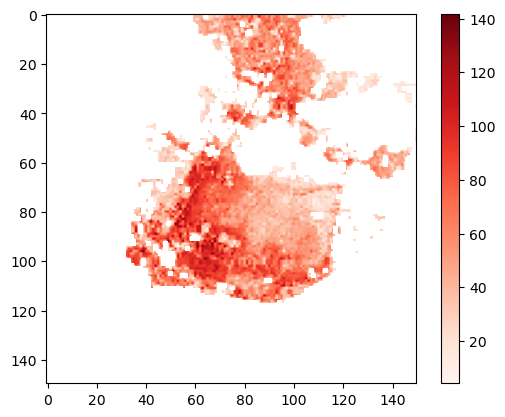

In [ ]:
#### Plot the population density map ####

cmap = mpl.colormaps['Reds']                                                 # set colormap              
norm = plt.Normalize(vmin=np.nanmin(popdens), vmax=np.nanmax(popdens))       # set normalization               
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)                           # create mappable                            

fig, ax = plt.subplots()                                                     # create figure and axes                           

im = ax.imshow(popdens, cmap=cmap)                                           # create image                               
cbar = fig.colorbar(mappable)                                                # add colorbar                     

plt.show()

### TODO solve MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. 
# Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
# cbar = fig.colorbar(mappable) 

### Visualize & calculate affected population
In the part below, some overlays are made to link flooding to population density to get info how many people are affected by the flood & how they are affected. The latter has been expressed by linking water depth to 'behavior' like wading and swimming.

In [188]:
### create overlays to get dry and flooded areas ###
overl_flarea = np.where(flood >= np.nanmin(flood),popdens,np.nan) 
overl_dryarea = np.where(np.isnan(flood),popdens,np.nan)


C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3725738846.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


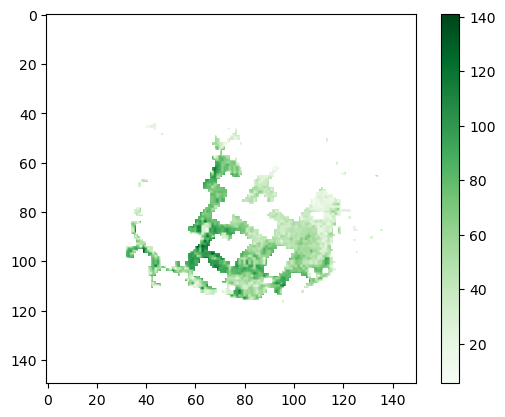

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3725738846.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


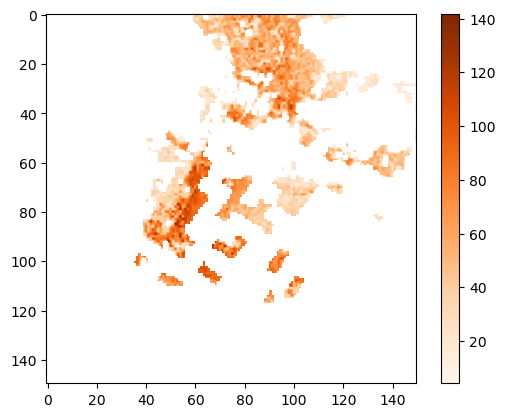

In [189]:
### plot the overlays ###

# plot the flooded area
cmap = mpl.colormaps['Greens']
norm = plt.Normalize(vmin=np.nanmin(overl_flarea), vmax=np.nanmax(overl_flarea))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots()

im = ax.imshow(overl_flarea, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

# plot the dry area
cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(overl_dryarea), vmax=np.nanmax(overl_dryarea))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots()

im = ax.imshow(overl_dryarea, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

In [198]:
### Give info on the population in the flooded and dry areas ###
print('total inhabitants in total area:', round(np.nansum(popdens),0))
print('total inhabitants in flooded area:', round(np.nansum(overl_flarea),0), '(', round((np.nansum(overl_flarea)/np.nansum(popdens))*100,0),'%)')
print('total inhabitants in dry area:', round(np.nansum(overl_dryarea),0), '(', round((np.nansum(overl_dryarea)/np.nansum(popdens))*100,0),'%)')
# print('total children in flooded area:', round(np.nansum (overl_flarea),0)), '(', round((np.nansum(overl_flarea)/np.nansum(children))*100,0),'%)'
# print('total adults in flooded area:', round(np.nansum (overl_flarea),0)), '(', round((np.nansum(overl_flarea)/np.nansum(adults))*100,0),'%)'


total inhabitants in total area: 347166.0
total inhabitants in flooded area: 137904.0 ( 40.0 %)
total inhabitants in dry area: 209261.0 ( 60.0 %)


In [ ]:
### Create claases for the flooded area ###

wclass = flood.copy()                                    # create a copy of the flood map
wclass[wclass>0]=np.nan                                  # filter the dry land out        
wclass[np.logical_and(wclass<0,wclass>=-0.1)]= 1         # assign the classes
wclass[np.logical_and(wclass<-0.1,wclass>=-0.5)]=2                                  
wclass[np.logical_and(wclass<-0.5,wclass>=-1.5)]=3
wclass[wclass<-1.5]= 4

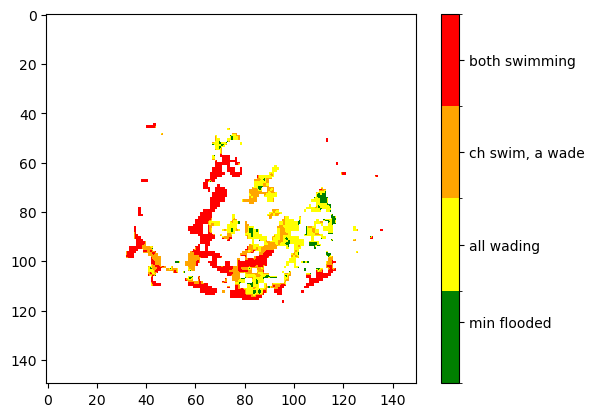

In [ ]:
### Plot the classes ###

cmap = ListedColormap(['green', 'yellow', 'orange', 'red'])
bounds = [0, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()

im = ax.imshow(wclass, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=[1,2, 3,4], boundaries=bounds)
cbar.ax.set_yticklabels(['min flooded', 'all wading', 'ch swim, a wade', 'both swimming'])
plt.show()

In [207]:
### Give info on the population in the flooded area and distinct between childs and adults ###

# make distinction between adults&children

ch_pop_class1 = round(np.nansum(children[wclass==1]),0) 
ch_pop_class2 = round(np.nansum(children[wclass==2]),0)
ch_pop_class3 = round(np.nansum(children[wclass==3]),0)
ch_pop_class4 = round(np.nansum(children[wclass==4]),0)

print('total children in flooded area:', round(np.nansum(children),0))
print('total children in minimum flooded area:', ch_pop_class1)
print('total children in area where everyone is wading:', ch_pop_class2)
print('total children in area where children swim and adults wade:', ch_pop_class3)
print('total children in area where everyone is swimming:', ch_pop_class4)

ad_pop_class1 = round(np.nansum(adults[wclass==1]),0)
ad_pop_class2 = round(np.nansum(adults[wclass==2]),0)
ad_pop_class3 = round(np.nansum(adults[wclass==3]),0)
ad_pop_class4 = round(np.nansum(adults[wclass==4]),0)

print('total adults in flooded area:', round(np.nansum(adults),0))    
print('total adults in minimum flooded area:', ad_pop_class1)
print('total adults in area where everyone is wading:', ad_pop_class2)
print('total adults in area where children swim and adults wade:', ad_pop_class3)
print('total adults in area where everyone is swimming:', ad_pop_class4)

# together with population data you know how many in each class, which can be highlighted in maps
print('total inhabitants in minimum flooded area:', round(np.nansum(wclass[wclass==1]),0),'(',round((np.nansum(wclass[wclass==1])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is wading:', round(np.nansum(wclass[wclass==2]),0),'(',round((np.nansum(wclass[wclass==2])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where children swim and adults wade:', round(np.nansum(wclass[wclass==3]),0),'(',round((np.nansum(wclass[wclass==3])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is swimming:', round(np.nansum(wclass[wclass==4]),0),'(',round((np.nansum(wclass[wclass==4])/np.nansum(wclass))*100,0),'%)')

# exposure data should be read in from text file
# read in dose response relations (via text file - link to different modules)

total children in flooded area: 45427.0
total children in minimum flooded area: 0.0
total children in area where everyone is wading: 2490.0
total children in area where children swim and adults wade: 2221.0
total children in area where everyone is swimming: 4758.0
total adults in flooded area: 155187.0
total adults in minimum flooded area: 0.0
total adults in area where everyone is wading: 1930.0
total adults in area where children swim and adults wade: 670.0
total adults in area where everyone is swimming: 4875.0
total inhabitants in minimum flooded area: 0.0 ( 0.0 %)
total inhabitants in area where everyone is wading: 1416.0 ( 22.0 %)
total inhabitants in area where children swim and adults wade: 1494.0 ( 23.0 %)
total inhabitants in area where everyone is swimming: 3648.0 ( 56.0 %)


### Import pathogen concentration with YAML file

In [ ]:
# Read YAML file
with open('Scenarios_Pathogen.yml', 'r') as file:
    data = yaml.safe_load(file)

pathogen_name = 'E.coli'
source_name = 'Sewer_and_pluvial'
conc_type = 'min'

# Find the pathogen
selected_pathogen = None
for pathogen in data['pathogens']:
    if pathogen['name'] == pathogen_name:
        selected_pathogen = pathogen
        break

if selected_pathogen:
    print('Selected pathogen:', selected_pathogen['name'])

    # Find the scenario for the given source
    selected_scenario = None
    for scenario in selected_pathogen['scenarios']:
        if scenario['source'] == source_name:
            selected_scenario = scenario
            break

    if selected_scenario:
        print('Used source:', selected_scenario['source'])
        print('Used unit:', selected_scenario['units'])

        # Retrieve the concentration based on the conc_type
        if conc_type == 'min':
            concentration = selected_scenario['min_conc']
            print('Using minimum concentration:', concentration)
        elif conc_type == 'max':
            concentration = selected_scenario['max_conc']
            print('Using maximum concentration:', concentration)
        else:
            print('Invalid concentration type')
    else:
        print('No scenario found for the specified source')
else:
    print('No pathogen found with the specified name')

PatConc = float(concentration)
print(PatConc)



Selected pathogen: E.coli
Used source: Sewer_and_pluvial
Used unit: MPN/ml
Using minimum concentration: 1000
1000.0


### Read in exposure data with YAML file and calculate ingested Dose 

In [ ]:
# Read exposure data from YAML file
with open("Exposure_scenarios.yml", "r") as file:
    exposure_data = yaml.safe_load(file)

# Retrieve concentration and unit for specific exposure scenarios
ad_sp = exposure_data["-Splashed_Adult"]["conc"]
ad_sw = exposure_data["-Swimming_Adult"]["conc"]
ch_pl = exposure_data["-Playing_Children"]["conc"]
ch_sw = exposure_data["-Swimming_Children"]["conc"]

unit_ad_sp = exposure_data["-Splashed_Adult"]["unit"]
unit_ad_sw = exposure_data["-Swimming_Adult"]["unit"]
unit_ch_pl = exposure_data["-Playing_Children"]["unit"]
unit_ch_sw = exposure_data["-Swimming_Children"]["unit"]

# Print the concentration and unit for the specific exposure scenarios
print("Splashed_Adult:")
print("  Concentration:", ad_sp)
print("  Unit:", unit_ad_sp)
print()

print("Swimming_Adult:")
print("  Concentration:", ad_sw)
print("  Unit:", unit_ad_sw)
print()

print("Playing_Children:")
print("  Concentration:", ch_pl)
print("  Unit:", unit_ch_pl)
print()

print("Swimming_Children:")
print("  Concentration:", ch_sw)
print("  Unit:", unit_ch_sw)
print()

# Perform dose calculations
dAd_sp = (PatConc / 1000) * ad_sp
dAd_sw = (PatConc/ 1000) * ad_sw
dCh_pl = (PatConc / 1000) * ch_pl
dCh_sw = (PatConc / 1000) * ch_sw

# Print the results
print(dAd_sp)
print(dAd_sw)
print(dCh_pl)
print(dCh_sw)

Splashed_Adult:
  Concentration: 10
  Unit: ml/event

Swimming_Adult:
  Concentration: 3.5
  Unit: ml/h

Playing_Children:
  Concentration: 30
  Unit: ml/d

Swimming_Children:
  Concentration: 50
  Unit: ml/h

10.0
3.5
30.0
50.0


### DOSE - Relate pathogen concentration to exposure levels
In this part, four flooding water depths are assumed: 0-0.10 (value 1), 0.1-0.5 (value 2),0.5-1.5 (value 3)and >1.5 (value 4). It is assumed that value 1 has no additional expore to not flooded, value 2 relates to wading of both children and adults, value 3 to swimming of children and wading by adults and value 4 both children and adults swim 


In [ ]:
# display ingestede dose for children and adults on map
wclass[wclass==1]=np.nan
dose_ad = wclass.copy()
dose_ad[np.logical_or(dose_ad==2,dose_ad==3)] = dAd_sp
dose_ad[dose_ad==4] = dAd_sw

dose_ch = wclass.copy()
dose_ch[dose_ch==2] = dCh_pl
dose_ch[np.logical_or(dose_ch==3,dose_ch==4)] = dCh_sw



C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\1365893742.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


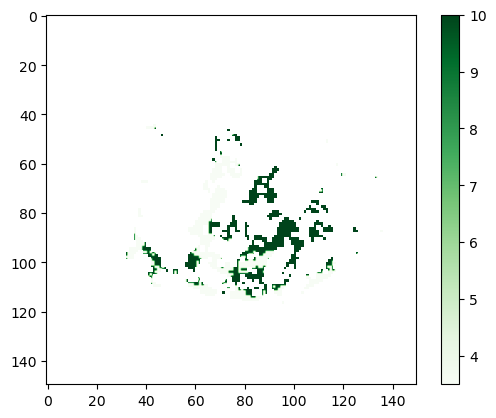

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\1365893742.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


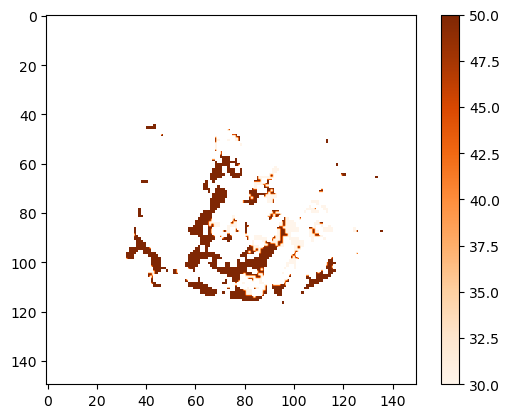

In [ ]:
cmap = mpl.colormaps['Greens']
norm = plt.Normalize(vmin=np.nanmin(dose_ad), vmax=np.nanmax(dose_ad))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(dose_ad, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(dose_ch), vmax=np.nanmax(dose_ch))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(dose_ch, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

### Calculate and map out infection Risk per exposure group

In [217]:
InfRisk_Ad_sp = 1 - (1+(dAd_sp/N50)*(2**(1/alpha)-1))**-alpha
InfRisk_Ad_sw = 1 - (1+(dAd_sw/N50)*(2**(1/alpha)-1))**-alpha

InfRisk_Ch_pl = 1 - (1+(dCh_pl/N50)*(2**(1/alpha)-1))**-alpha
InfRisk_Ch_sw = 1 - (1+(dCh_sw/N50)*(2**(1/alpha)-1))**-alpha

print(InfRisk_Ad_sp)
print(InfRisk_Ad_sw)
print(InfRisk_Ch_pl)
print(InfRisk_Ch_sw)



0.1147961381595558
0.053535518074158794
0.20711542215916856
0.2546819255059928
Total adults at risk in area where everyone is wading 0.0
Total adults at risk where everyone is wading 22155.65466479427
Total adults at risk where children are swimming and adults are wading 3586.879710968639
Total adults at risk where everyone is swimming 26098.565061152414
Total children at risk in area where everyone is wading 0.0
Total children at risk where everyone is wading 51571.74011763297
Total children at risk where children are swimming and adults are wading 56564.855654881
Total children at risk where everyone is swimming 121177.66015575136


In [ ]:
# display infection risk on map
inf_ad = wclass.copy()
inf_ad[np.logical_or(inf_ad==2,inf_ad==3)] = InfRisk_Ad_sp
inf_ad[inf_ad==4] = InfRisk_Ad_sw

inf_ch = wclass.copy()
inf_ch[inf_ch==2] =InfRisk_Ch_pl
inf_ch[np.logical_or(inf_ch==3,inf_ch==4)] = InfRisk_Ch_sw


C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3706364919.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


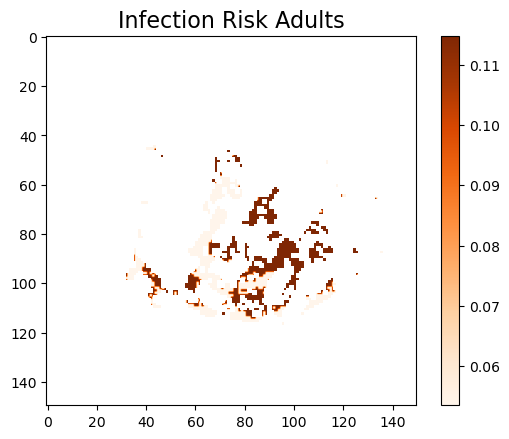

C:\Users\bleser\AppData\Local\Temp\ipykernel_29620\3706364919.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


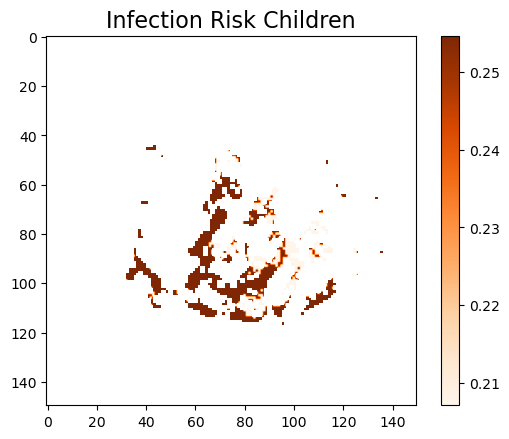

In [ ]:
# Map infection risk adults
cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(inf_ad), vmax=np.nanmax(inf_ad))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
plt.title('Infection Risk Adults', fontsize=16, color='black')
im = ax.imshow(inf_ad, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

plt.savefig(ds_out+'Infection Risk Adults.png')

#Map infection risk children 
cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(inf_ch), vmax=np.nanmax(inf_ch))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
plt.title('Infection Risk Children', fontsize=16, color='black')
im = ax.imshow(inf_ch, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

plt.savefig(ds_out+'Infection Risk Children.png')


In [218]:
#Population counts per infection risk class

# Should we save these results in the output folder? If yes, how?


Total_risk_ad_1 = ad_pop_class1 * InfRisk_Ad_sp * 100
Total_risk_ad_2 = ad_pop_class2 * InfRisk_Ad_sp * 100
Total_risk_ad_3 = ad_pop_class3 * InfRisk_Ad_sw * 100
Total_risk_ad_4 = ad_pop_class4 * InfRisk_Ad_sw * 100

Total_risk_ch_1 = ch_pop_class1 * InfRisk_Ch_pl * 100
Total_risk_ch_2 = ch_pop_class2 * InfRisk_Ch_pl * 100
Total_risk_ch_3 = ch_pop_class3 * InfRisk_Ch_sw * 100
Total_risk_ch_4 = ch_pop_class4 * InfRisk_Ch_sw * 100

print('Total adults at risk in area where everyone is wading', Total_risk_ad_1)
print('Total adults at risk where everyone is wading', Total_risk_ad_2)
print('Total adults at risk where children are swimming and adults are wading', Total_risk_ad_3)
print('Total adults at risk where everyone is swimming', Total_risk_ad_4)

print('Total children at risk in area where everyone is wading', Total_risk_ch_1)
print('Total children at risk where everyone is wading', Total_risk_ch_2)
print('Total children at risk where children are swimming and adults are wading', Total_risk_ch_3)
print('Total children at risk where everyone is swimming', Total_risk_ch_4)

Total adults at risk in area where everyone is wading 0.0
Total adults at risk where everyone is wading 22155.65466479427
Total adults at risk where children are swimming and adults are wading 3586.879710968639
Total adults at risk where everyone is swimming 26098.565061152414
Total children at risk in area where everyone is wading 0.0
Total children at risk where everyone is wading 51571.74011763297
Total children at risk where children are swimming and adults are wading 56564.855654881
Total children at risk where everyone is swimming 121177.66015575136


### Combine infection risk and population counts/adults/children

In [ ]:
#Estimate number of infections with infection risk for each exposure group per grid cell

#Multiply population in age groups with infection risk for each exposure group per grid cell
print(InfRisk_Ad_sp)
print(InfRisk_Ad_sw)
print(InfRisk_Ch_pl)
print(InfRisk_Ch_sw)

# Multiply population in age groups with infection risk for each exposure group per grid cell
Inf_Ad_sp = InfRisk_Ad_sp * adults
Inf_Ad_sw = InfRisk_Ad_sw * adults
Inf_Ch_pl = InfRisk_Ch_pl * children
Inf_Ch_sw = InfRisk_Ch_sw * children

print(Inf_Ad_sp)
print(Inf_Ad_sw)
print(Inf_Ch_pl)
print(Inf_Ch_sw)

#multiply each grid cell with the infection risk

print('total inhabitants in minimum flooded area:', round(np.nansum(wclass[wclass==1]),0),'(',round((np.nansum(wclass[wclass==1])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is wading:', round(np.nansum(wclass[wclass==2]),0),'(',round((np.nansum(wclass[wclass==2])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where children swim and adults wade:', round(np.nansum(wclass[wclass==3]),0),'(',round((np.nansum(wclass[wclass==3])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is swimming:', round(np.nansum(wclass[wclass==4]),0),'(',round((np.nansum(wclass[wclass==4])/np.nansum(wclass))*100,0),'%)')

flooded_population_total = round(np.nansum(overl_flarea),0)
#flooded_children_sw = 
#flooded_children_pl = 
#flooded_adults_wa = 
#flooded_adults_sw =  

print('Total Flooded Population:', flooded_population_total)
#print(flooded_children_pl)
#print(flooded_children_sw)
#print (flooded_adults_wa)
#print (flooded_adults_sw)

Infected_population = flooded_population_total * InfRisk_Ch_sw #max scenario for whole population, later distinction between vulnerability groups

print(Infected_population)

### Histogram Risk classes ###


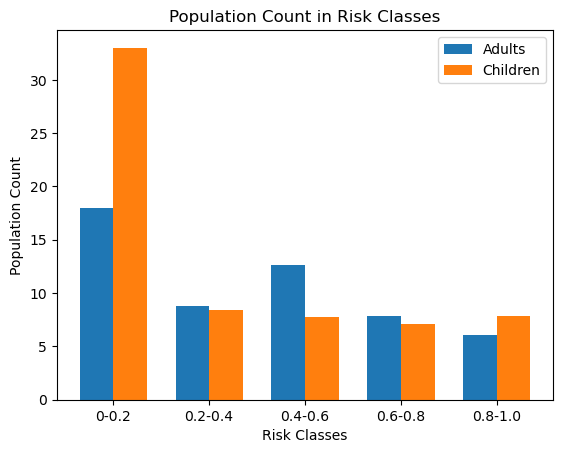

In [236]:


# Replace NaN values with 0
adults_population = np.nan_to_num(adults, nan=0)
children_population = np.nan_to_num(children, nan=0)

# Calculate the number of adults and children in each risk class
risk_classes = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
adults_count = np.zeros(len(risk_classes) - 1, dtype=float)
children_count = np.zeros(len(risk_classes) - 1, dtype=float)

for i in range(len(risk_classes) - 1):
    adults_mask = (inf_ad >= risk_classes[i]) & (inf_ad < risk_classes[i + 1])
    children_mask = (inf_ch >= risk_classes[i]) & (inf_ch < risk_classes[i + 1])

    adults_count[i] = np.sum(adults_mask * adults_population)
    children_count[i] = np.sum(children_mask * children_population)

# Plot histograms for adults and children
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(risk_classes) - 1)

ax.bar(index, adults_count, bar_width, label='Adults')
ax.bar(index + bar_width, children_count, bar_width, label='Children')

ax.set_xlabel('Risk Classes')
ax.set_ylabel('Population Count')
ax.set_title('Population Count in Risk Classes')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{risk_classes[i]}-{risk_classes[i + 1]}' for i in range(len(risk_classes) - 1)])
ax.legend()

plt.show()

plt.savefig(ds_out+'population_count_in_risk_classes')